| **Chapter**                   | 2:  Simple compartmental models                                                    |
| ----------------------------- |------------------------------------------------------------------------------------|
| **Computational Note**        | 2.x: Bayesian estimation of SIRD parameters                                        |
| **Package prerequisites**     | [PyMC3](https://docs.pymc.io/en/v3/), [Arviz](https://arviz-devs.github.io/arviz/) |


# Bayesian estimation of SIRD parameters

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as arz
import pymc3 as pm
import theano.tensor as tt
import theano

arz.style.use("arviz-darkgrid")

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [ ]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p theano

In [2]:
np.random.seed(42)

# Importing cases and mortality data

In [3]:
confirmed_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", sep=",")

In [4]:
start_date = "10/1/20"
end_date = "2/1/21"

In [5]:
cut_and_roll = lambda x: pd.Series(np.array(x.loc[x["Country/Region"] == "Hungary", start_date:end_date])[0]).rolling(7).mean().dropna().to_numpy()

cases_obs = cut_and_roll(confirmed_cases)
deaths_obs = cut_and_roll(deaths)

num_days = len(cases_obs)

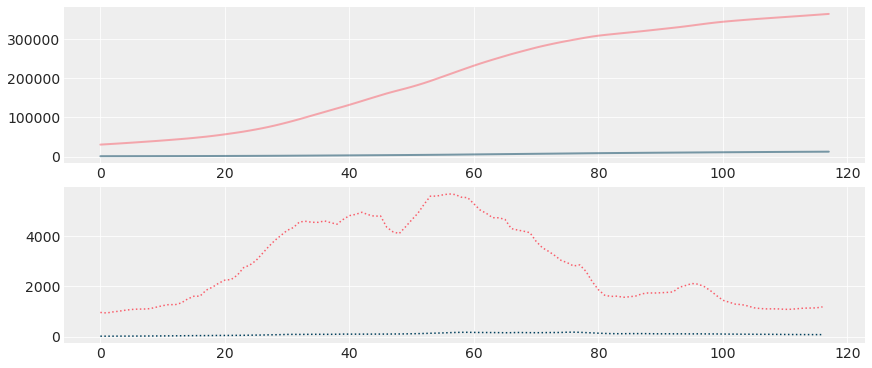

In [6]:
fig = plt.figure(facecolor="w", figsize=(12, 5))
ax1 = fig.add_subplot(211, axisbelow=True)

ax1.plot(cases_obs, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax1.plot(deaths_obs, color=COLORS["D"], alpha=0.5, lw=2, label="Deceased")

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(np.diff(cases_obs), color=COLORS["I"], linestyle=":")
ax2.plot(np.diff(deaths_obs), color=COLORS["D"], linestyle=":")

In [7]:
N = 9.769e6

I0 = cases_obs[0]
D0 = deaths_obs[0]
S0 = N - I0

In [8]:
def SIR_model(beta, gamma, S0, I0, D0, N):
    
    def next_day(beta, S_t, I_t, D_t, _, __):
        new_cases_at_t = beta/N * I_t * S_t
        removals_at_t = I_t * gamma
        deaths_at_t = removals_at_t * CFR
        I_t = I_t + new_cases_at_t - removals_at_t
        S_t = S_t - new_cases_at_t
        D_t = D_t + deaths_at_t

        return S_t, I_t, D_t, new_cases_at_t, deaths_at_t

    outputs , _  = theano.scan(fn=next_day, 
                               sequences=[beta], 
                               outputs_info=[np.float64(S0), 
                                             np.float64(I0), 
                                             np.float64(D0), 
                                             np.float64(np.diff(cases_obs)[0]),
                                             np.float64(np.diff(deaths_obs)[0])])
    
    S, I, D, new_cases, new_deaths = outputs
    
    return S, I, D, new_cases, new_deaths

## Setting up our model

The model estimates the set of parameters $\theta = \{ \beta, \gamma, \operatorname{CFR} \}$ based on the number of confirmed cases at time $t$ ($I_t$) and the number of deaths at the time $t$ ($D_t$).

Our initial parameters for $D_0$ and $I_0$ are the numbers on the first day in the data. We update $\theta$ using Markov chain Monte Carlo so as to minimise the distance between $\hat{\Delta I}(t) | \theta$ and $\Delta I(t)$ and $\hat{\Delta D}(t) | \theta$ and $\Delta D(t)$, respectively, where $\Delta C(t) = C(t) - C(t - 1) \forall C \in {I, D}$. We model the likelihoods using Student's T distribution with three degrees of freedom:

$$
    p(\hat{\Delta I}(t) | \theta) \sim \operatorname{T}_3 (\hat{\Delta I}(t) | \theta, \sigma_I \sqrt{\hat{\Delta I}(t) | \theta})
$$

$$
    p(\hat{\Delta D}(t) | \theta) \sim \operatorname{T}_3 (\hat{\Delta D}(t) | \theta, \sigma_D \sqrt{\hat{\Delta D}(t) | \theta})
$$

where 

$$
    \sigma_I \sim \operatorname{HalfCauchy}(1)
$$

$$
    \sigma_D \sim \operatorname{HalfCauchy}(1)
$$

For the model, we set some informative priors:

$$
    \beta \sim \operatorname{Lognormal}(\log(0.5), 0.2)
$$

$$
    \gamma \sim \operatorname{Lognormal}(\log(0.1), 0.1)
$$

$$
    \operatorname{CFR} \sim \operatorname{Lognormal}(\log(0.06), 0.1)
$$

In [9]:
with pm.Model() as model:
    
    # Estimating beta prior
    beta = pm.InverseGamma("beta", mu=0.5, sigma=0.1)

    # Estimating gamma prior
    gamma = pm.InverseGamma("gamma", mu=0.1, sigma=0.1)

    # Estimating CFR
    CFR = pm.TruncatedNormal("CFR", mu=0.005, sigma=0.01, lower=0, upper=1)

    # Deterministic caluclation of tau
    tau = pm.Deterministic("tau", 1/gamma)

    # Deterministic calculation of R_0
    R_0 = pm.Deterministic("R_0", (beta * (1 - CFR))/gamma)

    # Error term of the dIdt distribution
    sigma_I = pm.HalfCauchy("sigma_I", beta=1)
    sigma_D = pm.HalfCauchy("sigma_D", beta=1)
        
    # Evaluating the SIR model
    S, I, D, new_cases, new_deaths = SIR_model(beta=beta * tt.ones(num_days-1), 
                     gamma=gamma,
                     S0=S0, I0=I0, D0=D0, N=N)
    
    #Student T distribution for the observed cases
    cases = pm.StudentT("cases", nu=5, mu=new_cases, sigma=new_cases ** 0.5 * sigma_I, observed=np.diff(cases_obs))
    deaths = pm.StudentT("deaths", nu=5, mu=new_deaths, sigma=new_deaths ** 0.5 * sigma_D, observed=np.diff(deaths_obs))


    trace = pm.sample(draws=1000, tune=1000, chains=2)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_79331/1921925931.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=1000, tune=1000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/theano/tensor/

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 86 seconds.


In [10]:
with model:
    result = arz.from_pymc3(trace)

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'CFR'}>,
        <AxesSubplot:title={'center':'CFR'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'R_0'}>,
        <AxesSubplot:title={'center':'R_0'}>],
       [<AxesSubplot:title={'center':'sigma_I'}>,
        <AxesSubplot:title={'center':'sigma_I'}>],
       [<AxesSubplot:title={'center':'sigma_D'}>,
        <AxesSubplot:title={'center':'sigma_D'}>]], dtype=object)

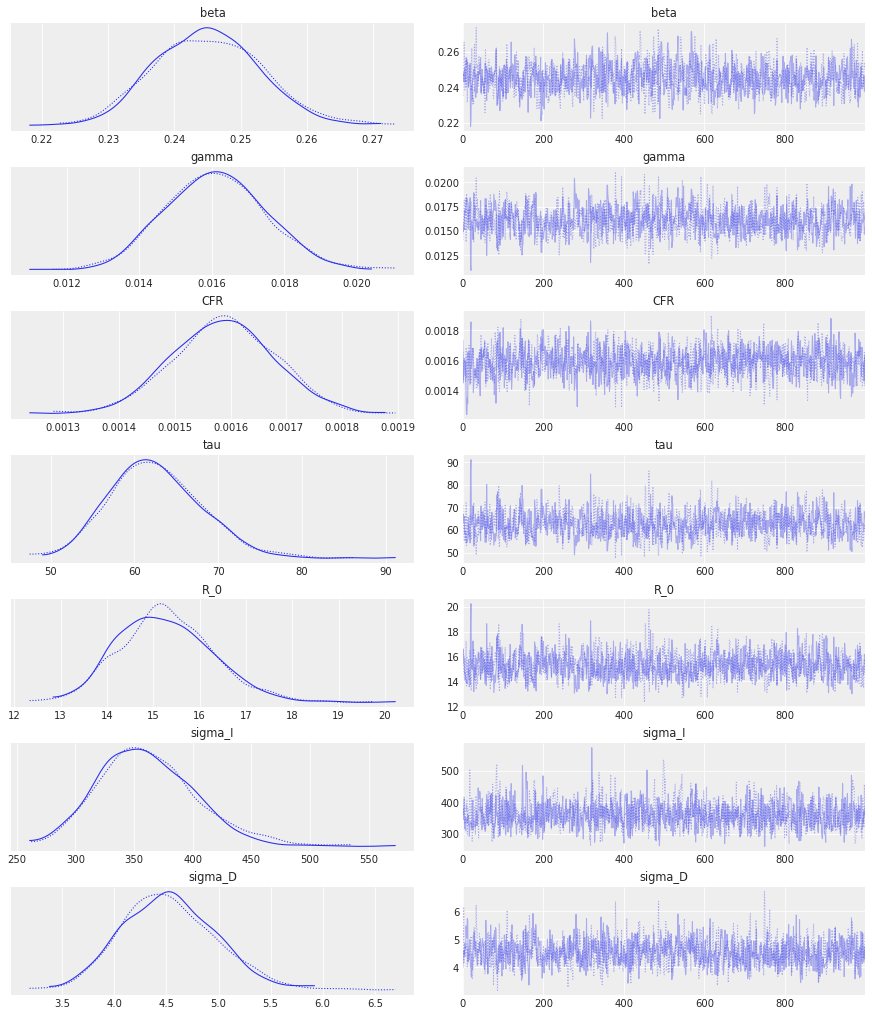

In [11]:
arz.plot_trace(result)

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'CFR'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'R_0'}>,
        <AxesSubplot:title={'center':'sigma_I'}>],
       [<AxesSubplot:title={'center':'sigma_D'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

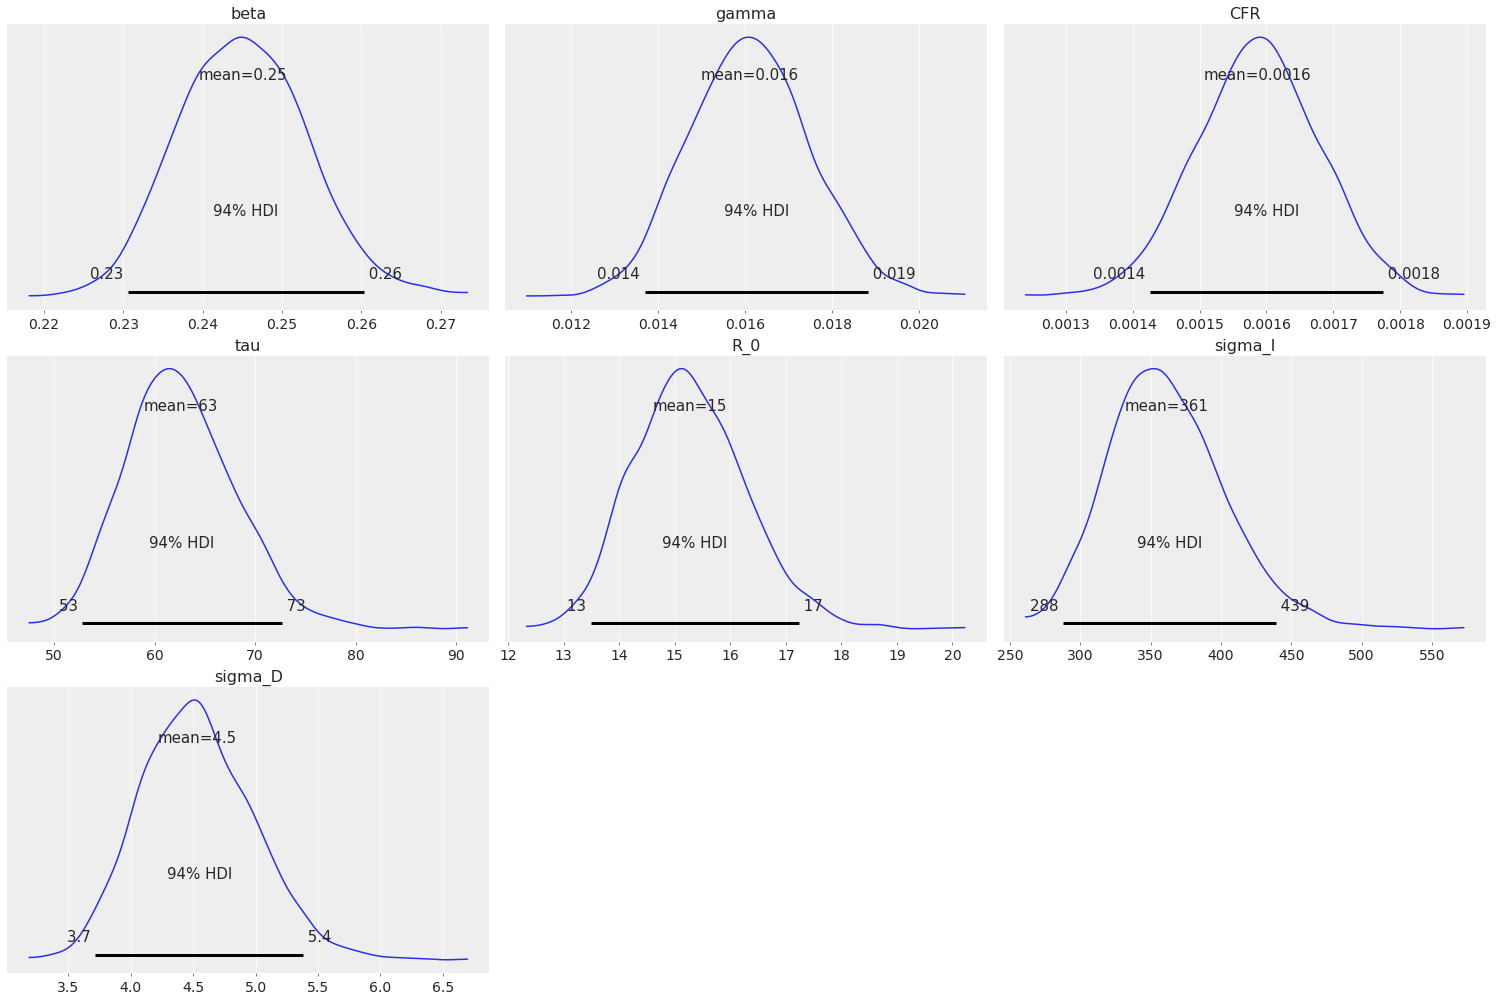

In [12]:
arz.plot_posterior(result)

<AxesSubplot:>

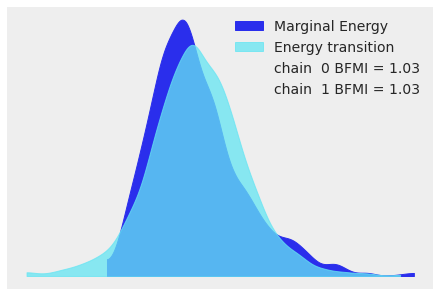

In [13]:
arz.plot_energy(result)

array([[<AxesSubplot:ylabel='gamma'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='CFR'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='tau'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='R_0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma_I'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='beta', ylabel='sigma_D'>,
        <AxesSubplot:xlabel='gamma'>, <AxesSubplot:xlabel='CFR'>,
        <AxesSubplot:xlabel='tau'>, <AxesSubplot:xlabel='R_0'>,
        <AxesSubplot:xlabel='sigma_I'>]], dtype=object)

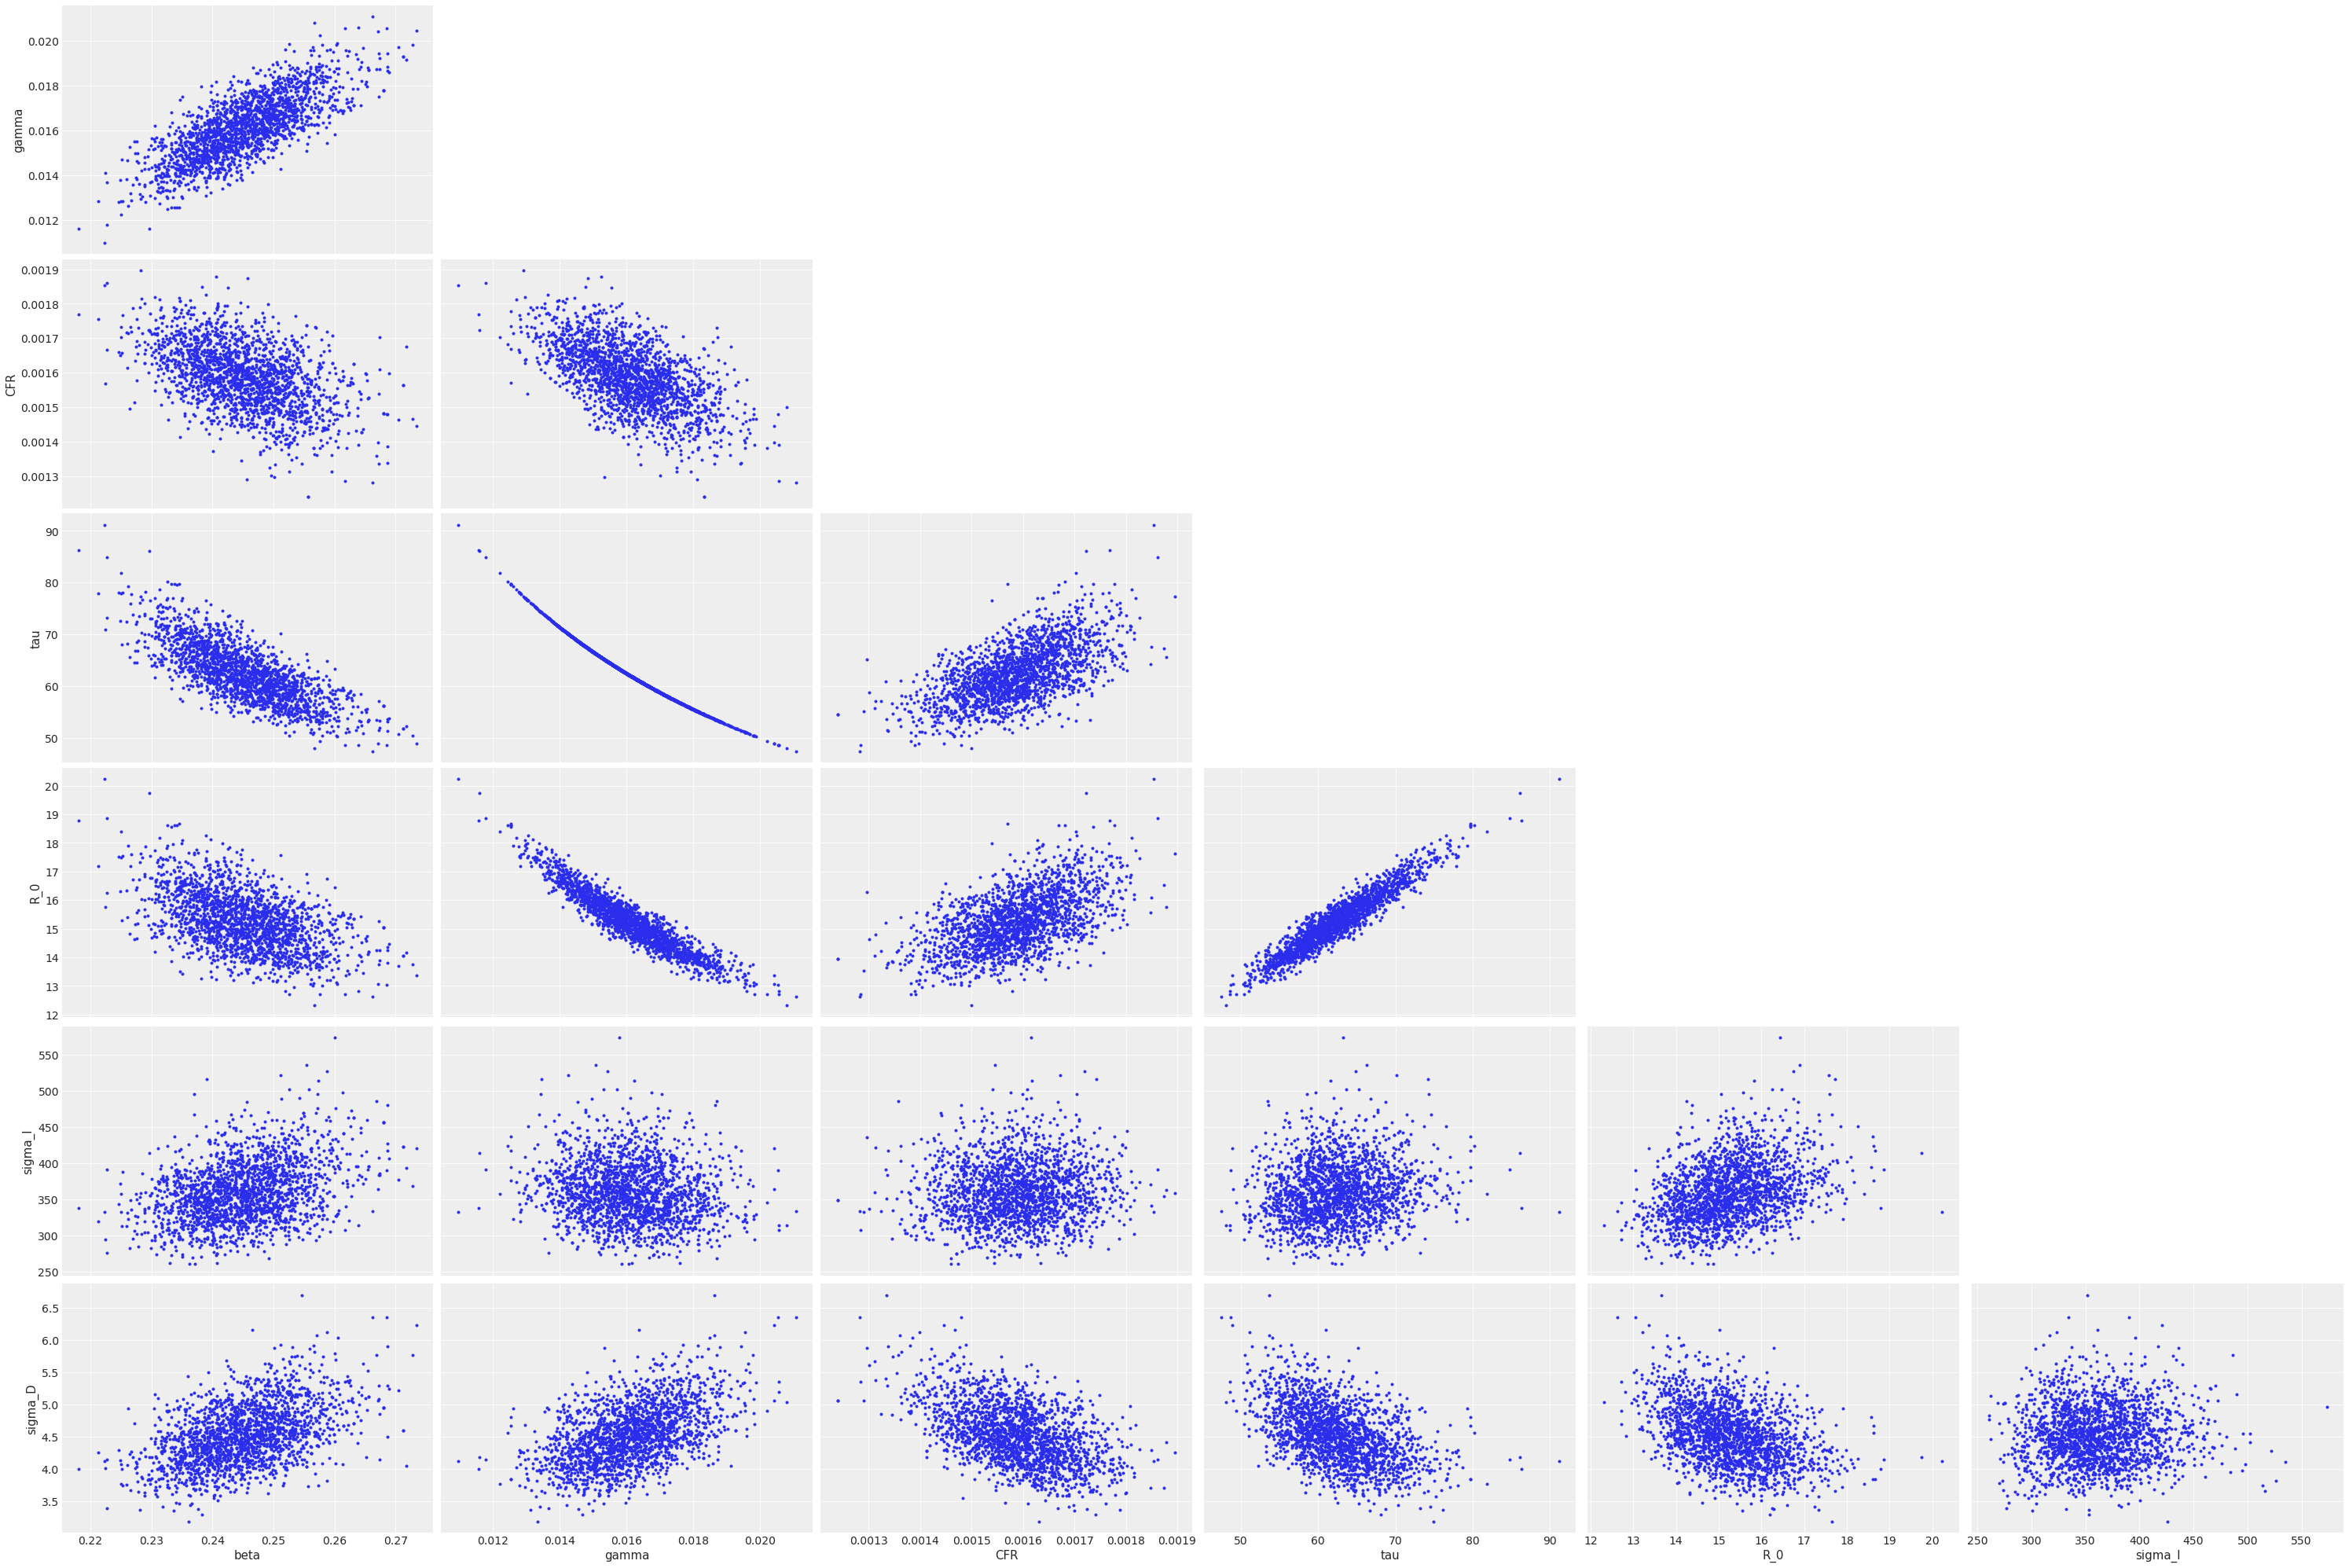

In [14]:
arz.plot_pair(result)

In [15]:
arz.summary(result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.245,0.008,0.231,0.260,0.000,0.000,922.0,1003.0,1.0
gamma,0.016,0.001,0.014,0.019,0.000,0.000,829.0,1239.0,1.0
CFR,0.002,0.000,0.001,0.002,0.000,0.000,1046.0,1312.0,1.0
tau,62.551,5.510,52.792,72.659,0.187,0.132,829.0,1239.0,1.0
R_0,15.276,1.011,13.487,17.238,0.032,0.023,943.0,1163.0,1.0
sigma_I,361.463,41.484,287.753,439.441,1.152,0.834,1379.0,901.0,1.0
sigma_D,4.533,0.458,3.717,5.383,0.014,0.010,1108.0,1295.0,1.0
